<a href="https://colab.research.google.com/github/simaafshar/MNase-data/blob/master/Landmark_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
#Import package
import numpy as np
import cv2
import pandas as pd


In [47]:
#Define a dataloader and dataset
#1)Dataset _> 2)Dataloader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
import cv2
import PIL
from torchvision.transforms import transforms
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# AutoAugment
class tick_dataset(Dataset):
  def __init__(self,path,train=True):
    self.transform = transforms.Compose([transforms.ToTensor()])
    self.data = pd.read_excel(path)
    self.x = self.data.values[:,1:]
    self.name = self.data.values[:,0]
    self.name = np.array([np.char.strip(x,' ') for x in self.name])
    self.name = np.array([np.char.strip(x,'.') for x in self.name])

    self.labels_file = pd.read_csv("/content/drive/MyDrive/Tick_labels/All_Ticks_Dorsal_Classifier 2.csv")
    self.id = self.labels_file.values[:,1]
    self.id = np.array([np.char.strip(x,' ') for x in self.id])
    self.id = np.array([np.char.strip(x,'.') for x in self.id])
    enc = LabelEncoder()
    self.sex = self.labels_file.values[:,3]
    self.spc = self.labels_file.values[:,2]
    self.loc = self.labels_file.values[:,14]
    self.sex = enc.fit_transform(self.sex)
    self.spc = enc.fit_transform(self.spc)
    self.loc = enc.fit_transform(self.loc)
    self.train_id, self.test_id = train_test_split(self.id,test_size=0.2,random_state = 0)
    if train:
      self.selected_id = self.train_id
    else:
      self.selected_id = self.test_id

  def __len__(self):
    return len(self.selected_id)

  def __getitem__(self, idx):
    id = self.selected_id[idx]
    x_id = np.where(self.name == id)[0][0]
    x = np.array(self.x[x_id])
    x = x.astype('float')
    y_id = np.where(self.id == id)[0][0]
    sex = self.sex[y_id]
    spc = self.spc[y_id]
    loc = self.loc[y_id]
    # return self.transform(img),np.array(l1).reshape(1,1),np.array(l2).reshape(1,1)
    
    return x,[sex,spc,loc]



In [28]:
dataset_train = tick_dataset("/content/drive/MyDrive/Landmarks/Dorsal_Coords_All_Ticks.xlsx")
dataset_test = tick_dataset("/content/drive/MyDrive/Landmarks/Dorsal_Coords_All_Ticks.xlsx",train=False)
print(len(dataset_train))
print(len(dataset_test))

395
99


In [39]:
## groups of 16 images go throught into network

#Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [40]:

from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU, Sigmoid, Sequential, BatchNorm1d
#fully connected nn
class my_fc(torch.nn.Module):
  def __init__(self,input_num):
    super(my_fc,self).__init__()
    self.l1 = Linear(input_num,64)
    self.l2 = Linear(64,128)
    self.l3 = Linear(128,128)
    self.l4 = Linear(128,64)
    self.l5 = Linear(64,16)
    self.l_out = Linear(16,1)
    self.relu = ReLU()


  def forward(self,x):
    x = self.l1(x)
    x = self.l2(x)
    x = self.relu(x) 
    x = self.l3(x)
    x = self.relu(x) 
    x = self.l4(x)
    x = self.relu(x) 
    x = self.l5(x)
    x = self.relu(x) 
    x = self.l_out(x)
    o = Sigmoid()(x)
    return o

model = my_fc(input_num=20)
model = model.cuda()
from torchsummary import summary
summary(model, (1,20),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [32, 1, 64]           1,344
            Linear-2               [32, 1, 128]           8,320
              ReLU-3               [32, 1, 128]               0
            Linear-4               [32, 1, 128]          16,512
              ReLU-5               [32, 1, 128]               0
            Linear-6                [32, 1, 64]           8,256
              ReLU-7                [32, 1, 64]               0
            Linear-8                [32, 1, 16]           1,040
              ReLU-9                [32, 1, 16]               0
           Linear-10                 [32, 1, 1]              17
Total params: 35,489
Trainable params: 35,489
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.14
Estimated Tot

In [41]:
#Training
from torch.nn import CrossEntropyLoss, BCELoss
from torch.optim import SGD, Adam
Epoch_number = 400
loss_function = BCELoss()
# optimizor = SGD(model.parameters(),0.001)
optimizor = Adam(model.parameters())

In [42]:
!pip install barbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
from barbar import Bar
from sklearn.metrics import accuracy_score

In [44]:
# save loss
all_loss = []
best_acc = 0
#1 for DIV/IS and 2 for F/M and 3 location
label_num = 2
for epoch in range(Epoch_number):
  print("Epoch: ", epoch)
  for x,[sex,spc,loc] in Bar(train_dataloader):
    x = x.float()
    x = x.cuda()
    #Choose between l2 or l1
    if label_num==1:
      labels = sex.cuda().float()
    elif label_num==2:
      labels = spc.cuda().float()
    else:
      labels = loc.cuda().float()

    pred = model(x)
    loss = loss_function(pred[:,0],labels)
    optimizor.zero_grad()
    loss.backward()
    optimizor.step()
    all_loss.append(loss.item())

  pred_all = []
  label_all = []
  for x,[sex,spc,loc] in Bar(train_dataloader):
    x = x.float()
    x = x.cuda()
    #Choose between l2 or l1
    if label_num==1:
      labels = sex.cuda().float()
    elif label_num==2:
      labels = spc.cuda().float()
    else:
      labels = loc.cuda().float()

    pred = model(x)
    pred_all = np.concatenate((pred_all,pred.cpu().detach().numpy()[:,0]))
    label_all = np.concatenate((label_all, labels.cpu()))

  acc = accuracy_score((pred_all>0.5).astype('int'),label_all)
  print("Accuracy on the test set is:",acc)
  if (acc) > best_acc:
    print("Best accuracy is updated")
    print("Saving model...")
    best_acc = (acc)
    torch.save(model.state_dict(),"/content/drive/MyDrive/runs/model.pth")




Epoch:  0
395/395: [=============================>..] - ETA 0.0s
395/395: [=============================>..] - ETA 0.0s
Accuracy on the test set is: 0.7139240506329114
Best accuracy is updated
Saving model...
Epoch:  1
395/395: [=============================>..] - ETA 0.0s
395/395: [=============================>..] - ETA 0.0s
Accuracy on the test set is: 0.7139240506329114
Epoch:  2
395/395: [=============================>..] - ETA 0.0s
395/395: [=============================>..] - ETA 0.0s
Accuracy on the test set is: 0.7139240506329114
Epoch:  3
395/395: [=============================>..] - ETA 0.0s
395/395: [=============================>..] - ETA 0.0s
Accuracy on the test set is: 0.7139240506329114
Epoch:  4
395/395: [=============================>..] - ETA 0.0s
395/395: [=============================>..] - ETA 0.0s
Accuracy on the test set is: 0.7139240506329114
Epoch:  5
395/395: [=============================>..] - ETA 0.0s
395/395: [=============================>..] - ETA 0.0s

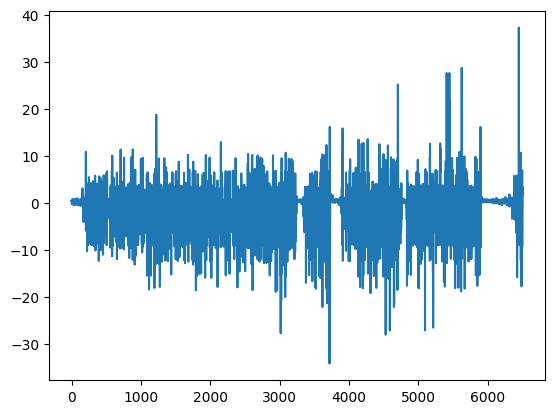

In [16]:
import matplotlib.pyplot as plt

plt.plot(all_loss)

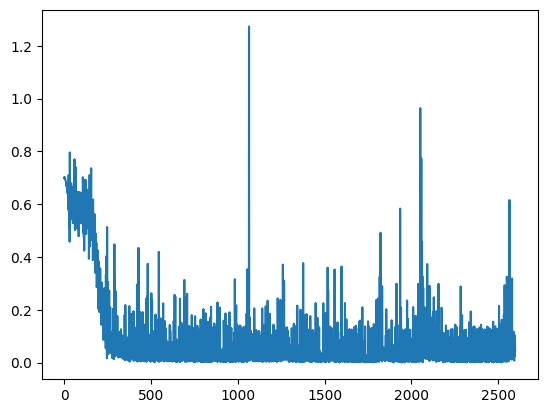

In [ ]:

plt.plot(all_loss)

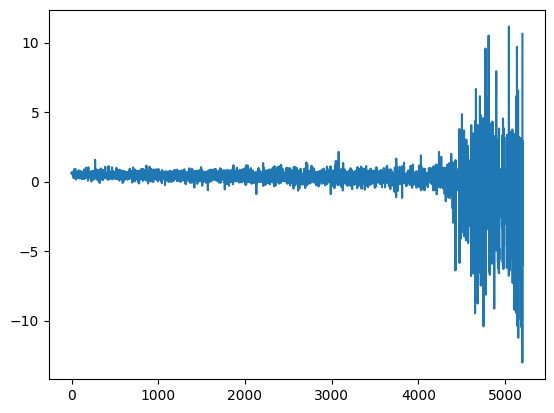

In [ ]:
plt.plot(all_loss)